## bernoulli AR Results 

This notebook goes over the code needed to reproduce the results from the MSE and time figures in the first simulation in the paper. 

In this example we have bernoulli base distribution with Logit Link function and covariance matrix $\Gamma$ structured under AR covariance with $\rho = 0.9, \sigma^2 = 0.1$

In [32]:
versioninfo()

Julia Version 1.6.2
Commit 1b93d53fc4 (2021-07-14 15:36 UTC)
Platform Info:
  OS: macOS (x86_64-apple-darwin18.7.0)
  CPU: Intel(R) Core(TM) i9-9880H CPU @ 2.30GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-11.0.1 (ORCJIT, skylake)


In [33]:
using GLMCopula, DelimitedFiles, LinearAlgebra, Random, GLM
using Random, Roots, SpecialFunctions, DataFrames

In [34]:
p  = 3    # number of fixed effects, including intercept

# true parameter values
Random.seed!(1234)
βtrue = rand(Uniform(-0.2, 0.2), p)
σ2true = [0.5]
ρtrue = [0.9]

# generate data
trueparams = [βtrue; σ2true; ρtrue] #hold true parameters

#simulation parameters
samplesizes = [100; 1000; 10000]
ns = [5; 10; 20; 50; 100]
nsims = 100

100

In [36]:
@info "reading in the files with results"
βMseresult = vec(readdlm("mse_beta_multivariate_bernoulli_AR$(nsims)reps_sim.csv", ','))
σ2MseResult = vec(readdlm("mse_sigma_multivariate_bernoulli_AR$(nsims)reps_sim.csv", ','))
ρMseResult = vec(readdlm("mse_rho_multivariate_bernoulli_AR$(nsims)reps_sim.csv", ','))
fittimes = vec(readdlm("fittimes_multivariate_bernoulli_AR$(nsims)reps_sim.csv", ','))

┌ Info: reading in the files with results
└ @ Main In[36]:1


1500-element Vector{Float64}:
   0.25755856
   0.68319995
   0.185291776
   0.599437681
   0.257948252
   0.683006425
   0.210180276
   0.229477104
   0.136937462
   0.231144236
   0.244308524
   0.182510567
   0.199584778
   ⋮
 123.391440731
 NaN
 239.964865252
 230.203613847
 161.958449584
 NaN
 NaN
 219.835938155
 220.218677553
 121.786298885
 189.341046756
 155.159981092

In [37]:
#simulation parameters
@info "making results table"
sample_sizes = repeat(string.(samplesizes), inner = nsims * length(ns))
obs_sizes = repeat(string.(ns), inner = nsims, outer = length(samplesizes))

msedf = DataFrame(βmse = βMseresult, σ2mse = σ2MseResult, ρmse = ρMseResult,
    samplesize = sample_sizes, obssize = obs_sizes, fittimes = fittimes)
timedf = combine(groupby(msedf, [:samplesize, :obssize]), :fittimes => mean => :fittime,
    :fittimes => x -> (std(x)/sqrt(length(x))))
rename!(timedf, Dict(:fittimes_function => "se"))
timedf[!, :nobs] = Meta.parse.(timedf[!, :samplesize]) .* Meta.parse.(timedf[!, :obssize])
timedf[!, :fitmin] = timedf[!, :fittime] - timedf[!, :se]
timedf[!, :fitmax] = timedf[!, :fittime] + timedf[!, :se]
timedf[!, :perobsratio] = timedf[!, :fittime] ./ timedf[!, :nobs]
timedf

┌ Info: making results table
└ @ Main In[37]:2


,samplesize,obssize,fittime,se,nobs,fitmin,fitmax,perobsratio
,String,String,Float64,Float64,Int64,Float64,Float64,Float64
1,100,5,0.284484,0.0167287,500,0.267755,0.301212,0.000568967
2,100,10,0.31738,0.0189344,1000,0.298445,0.336314,0.00031738
3,100,20,NaN,NaN,2000,NaN,NaN,NaN
4,100,50,NaN,NaN,5000,NaN,NaN,NaN
5,100,100,NaN,NaN,10000,NaN,NaN,NaN
6,1000,5,0.336288,0.00952818,5000,0.32676,0.345816,6.72576e-5
7,1000,10,0.455942,0.0133795,10000,0.442562,0.469321,4.55942e-5
8,1000,20,0.874648,0.0279188,20000,0.846729,0.902567,4.37324e-5
9,1000,50,NaN,NaN,50000,NaN,NaN,NaN


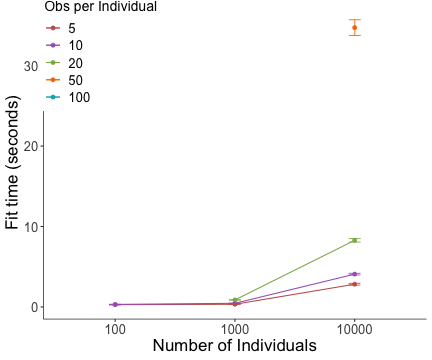

RObject{VecSxp}


┌ Warning: RCall.jl: Warning: Removed 6 row(s) containing missing values (geom_path).
│ Warning: Removed 6 rows containing missing values (geom_point).
└ @ RCall /Users/sarahji/.julia/packages/RCall/iMDW2/src/io.jl:160


In [38]:
########### plot the runtimes
using RCall
@rput timedf

R"""
library(ggplot2)
timedf$obssize = factor(timedf$obssize, levels = c('5', '10', '20', '50', '100'))
timedf$samplesize = factor(timedf$samplesize, levels = c('100', '1000', '10000'))

fittime_1 = ggplot(timedf, aes(x = samplesize, y = fittime, group = obssize, color = obssize)) + 
  geom_line() +
  geom_point()+
  geom_errorbar(aes(ymin=fitmin, ymax=fitmax), width=0.5, alpha = 0.8, position=position_dodge(0.005)) + 
  theme(legend.position=c(0.15,0.85), legend.key = element_blank(), axis.text.x = element_text(angle=0, size=13),
        axis.text.y = element_text(angle=0, size=13), axis.title.x = element_text(size = 17), 
        axis.title.y = element_text(size = 17), legend.title = element_text(size = 14),
        #axis.ticks = element_blank(),
        panel.grid.major = element_blank(), legend.text=element_text(size=13),
        panel.border = element_blank(), panel.grid.minor = element_blank(), panel.background = element_blank(), 
        axis.line = element_line(color = 'black',size=0.3), plot.title = element_text(hjust = 0.5)) + 
   scale_color_manual(values = c("#c85f55",
"#a964bf",
"#8db352",
"#fa7300",
"#05aec0",
"#ff1493")) +
  labs(x = "Number of Individuals", y = "Fit time (seconds)", color = "Obs per Individual")
"""

In [27]:
R"""
ggsave('fittime_nsamples_bernoulli_AR.png', fittime_1, width = 12.5, height = 15, units = 'in', dpi = 450)
"""

RObject{StrSxp}
[1] "fittime_nsamples_bernoulli_AR.png"


In [39]:
######  supplementary table s1
using Random, DataFrames, DelimitedFiles, Statistics
import StatsBase: sem

βρσ2coverage = readdlm("beta_rho_sigma_coverage_multivariate_bernoulli_AR$(nsims)reps_sim.csv", ',')

m = 2

covdf = DataFrame(Matrix(transpose(βρσ2coverage)), :auto)
rename!(covdf, Symbol.([["β$i" for i in 1:p]; ["σ2"];  ["ρ"]]))
covdf[!, :samplesize] = sample_sizes
covdf[!, :obssize] = obs_sizes
first(covdf, 10)

row_stats = [[(mean(col), sem(col)) for col = eachcol(d[!, 1:end-2])] for d = groupby(covdf, [:samplesize; :obssize])]
df = DataFrame(row_stats, :auto)
ss_obs = unique("N: " .* sample_sizes .* "  ni: " .* obs_sizes)
rename!(df, Symbol.(ss_obs))
covdfdisplay = DataFrame([[names(df)]; collect.(eachrow(df))], 
    [:people_obs; Symbol.([["β$i" for i in 1:p]; ["σ2"]; ["ρ"]])])
# deletecols!(covdfdisplay, p + 2)
covdfdisplay


,people_obs,β1,β2,β3,σ2
,String,Tuple…,Tuple…,Tuple…,Tuple…
1,N: 100 ni: 5,"(0.74, 0.0440844)","(0.68, 0.0468826)","(0.71, 0.0456048)","(0.1, 0.0301511)"
2,N: 100 ni: 10,"(0.81, 0.0394277)","(0.73, 0.0446196)","(0.87, 0.0337998)","(0.01, 0.01)"
3,N: 100 ni: 20,"(NaN, NaN)","(NaN, NaN)","(NaN, NaN)","(NaN, NaN)"
4,N: 100 ni: 50,"(NaN, NaN)","(NaN, NaN)","(NaN, NaN)","(NaN, NaN)"
5,N: 100 ni: 100,"(NaN, NaN)","(NaN, NaN)","(NaN, NaN)","(NaN, NaN)"
6,N: 1000 ni: 5,"(0.81, 0.0394277)","(0.62, 0.0487832)","(0.83, 0.0377525)","(0.0, 0.0)"
7,N: 1000 ni: 10,"(0.89, 0.0314466)","(0.55, 0.05)","(0.84, 0.0368453)","(0.0, 0.0)"
8,N: 1000 ni: 20,"(0.93, 0.0256432)","(0.55, 0.05)","(0.83, 0.0377525)","(0.0, 0.0)"
9,N: 1000 ni: 50,"(NaN, NaN)","(NaN, NaN)","(NaN, NaN)","(NaN, NaN)"


In [43]:
#### 
#import data and reorganize to create figure
using Random, DataFrames, DelimitedFiles, Statistics, RCall, Printf
import StatsBase: sem

βMseresult_1 = vec(readdlm("mse_beta_multivariate_bernoulli_AR$(nsims)reps_sim.csv", ','))
σ2MseResult_1 = vec(readdlm("mse_sigma_multivariate_bernoulli_AR$(nsims)reps_sim.csv", ','))
ρMseResult_1 = vec(readdlm("mse_rho_multivariate_bernoulli_AR$(nsims)reps_sim.csv", ','))
βρσ2coverage_1 = readdlm("beta_rho_sigma_coverage_multivariate_bernoulli_AR$(nsims)reps_sim.csv", ',')

samplesizesrobust = samplesizes
nsrobust = ns
nsimsrobust = nsims

p = 3
sample_sizesrobust = repeat(string.(samplesizesrobust), inner = nsimsrobust * length(nsrobust))
obs_sizesrobust = repeat(string.(nsrobust), inner = nsimsrobust, outer = length(samplesizesrobust))
msedfrobust = DataFrame(βmse = βMseresult_1, σ2mse = σ2MseResult_1, ρmse = ρMseResult_1,
    samplesize = sample_sizesrobust, obssize = obs_sizesrobust)


msedfrobustR = deepcopy(msedfrobust)
rename!(msedfrobustR, ["betamse"
    "sigmamse"
        "rhomse"
    "samplesize"
 "obssize"]);

mses = [msedfrobustR[!, :betamse]; msedfrobustR[!, :sigmamse] ; msedfrobustR[!, :rhomse]]
    # msedfnormR[!, :betamse]; msedfnormR[!, :taumse]; msedfnormR[!, :Sigmamse]]
obssize = collect([repeat(msedfrobustR[!, :obssize], 3)]...)

samplesize = collect([repeat(msedfrobustR[!, :samplesize], 3)]...) 

parameters = collect([repeat(string.([:beta, :sigma, :rho]), inner = nsimsrobust * length(nsrobust) * length(samplesizesrobust))]...)
robust = collect([repeat(["Bernoulli with LogitLink"], 3 * nsimsrobust * length(nsrobust) * length(samplesizesrobust))]...) # ;

msedfR = DataFrame(mse = mses, obssize = obssize, samplesize = samplesize,
    parameters = parameters, robust = robust)

#5 of the 30,000 simulations did not converge, filter out
msedfR = filter(x -> !isnan(x.mse), msedfR)
# additionally, there are 5 where an error was not caught so it did not try a differnt solver
msedfR = filter(x -> x.mse < 200, msedfR)

,mse,obssize,samplesize,parameters,robust
,Float64,String,String,String,String
1,0.0133634,5,100,beta,Bernoulli with LogitLink
2,0.0252184,5,100,beta,Bernoulli with LogitLink
3,0.000683405,5,100,beta,Bernoulli with LogitLink
4,0.0121072,5,100,beta,Bernoulli with LogitLink
5,0.00835273,5,100,beta,Bernoulli with LogitLink
6,0.010209,5,100,beta,Bernoulli with LogitLink
7,0.00271487,5,100,beta,Bernoulli with LogitLink
8,0.0219295,5,100,beta,Bernoulli with LogitLink
9,0.0105289,5,100,beta,Bernoulli with LogitLink


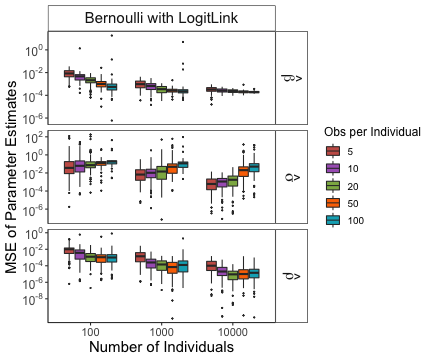

RObject{VecSxp}


In [44]:
### working on figure next
@rput msedfR

R"""
library(scales)
library(ggplot2)
library(data.table)

msedfR = data.table(msedfR)

msedfR[parameters == "beta",y_min := 10^-4]
msedfR[parameters == "beta",y_max := 10^1]
msedfR[parameters == "sigma",y_min := 10^-5]
msedfR[parameters == "sigma",y_max := 10^1]
msedfR[parameters == "rho",y_min := 10^-5]
msedfR[parameters == "rho",y_max := 10^-2]

#msedfR[parameters == "beta",y_min := 10^-8]
#msedfR[parameters == "beta",y_max := 10^-2]
#msedfR[parameters == "tau",y_min := 10^-8]
#msedfR[parameters == "tau",y_max := 10^-2]
#msedfR[parameters == "Sigma",y_min := 10^-5]
#msedfR[parameters == "Sigma",y_max := 10^-2]


msedfR$obssize = factor(msedfR$obssize, levels = c('5', '10', '20', '50', '100'))
msedfR$samplesize = factor(msedfR$samplesize, levels = c('100', '1000', '10000'))
msedfR$parameters = factor(msedfR$parameters, levels = c('beta', 'sigma', 'rho'), labels = c(beta = expression(hat(bold(beta))), Sigma = expression(hat(bold(sigma))[]), rho = expression(hat(bold(rho)))))
msedfR$robust = factor(msedfR$robust, levels = c('Bernoulli with LogitLink'),
    labels = c(expression(paste("Bernoulli with LogitLink")))) # , expression(paste("MvT Gamma Inverse-Gamma"))))


#mseplot <- ggplot(msedfR[msedfR$mse < 10^0, ], aes(x=samplesize, y=mse, fill=obssize)) + 
mseplot = ggplot(msedfR[msedfR$mse < 10^3, ], aes(x=samplesize, y=mse, fill=obssize)) + 
  #geom_boxplot(outlier.size = 0.0, outlier.alpha = 0) +
  geom_boxplot(outlier.size = 0.25) +
#    geom_violin() +
    facet_grid(parameters ~ robust, labeller = label_parsed, scales = "free_y") +
  theme(legend.position="right", legend.key = element_blank(), axis.text.x = element_text(angle=0, size=11),
        axis.text.y = element_text(angle=0, size=12), axis.title.x = element_text(size = 15), 
        axis.title.y = element_text(size = 15), legend.title = element_text(size = 12),
        panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
        legend.text=element_text(size=10), panel.background = element_rect(fill = NA, color = "black"),
        #panel.background = element_blank(), #panel.border = element_blank(),
        axis.line = element_line(color = 'black',size=0.3), plot.title = element_text(hjust = 0.5),
        strip.background = element_rect(colour="black", fill="white"), strip.text.y = element_text(size=15, face="bold"),
        strip.text.x = element_text(size=15)) + 
  scale_fill_manual(values = c("#c85f55",
"#a964bf",
"#8db352",
"#fa7300",
"#05aec0",
"#ff1493")) +
#scale_y_log10(breaks = scales::trans_breaks("log10", function(x) 10^x)) +
#scale_y_log10(breaks = 10^(-8:8), limit=c(10^-8, 10^2)) + 
scale_y_log10(breaks = 10^seq(-8, 8, 2), labels=trans_format("log10", math_format(10^.x))) + #, limit=c(10^-8, 10^2)) +
  labs(x = "Number of Individuals", y = "MSE of Parameter Estimates", fill = "Obs per Individual") +
geom_blank(aes(y = y_max)) + 
geom_blank(aes(y = y_min)) 

"""

In [45]:
R"""
ggsave('updated_msefacetplot_bernoulli_AR.png', mseplot, width = 12.5, height = 15, units = 'in', dpi = 450)
"""

RObject{StrSxp}
[1] "updated_msefacetplot_bernoulli_AR.png"
